In [442]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

import xgboost as xgb




# READ THE CSV'S 


In [443]:
# Read the original CSV files (only once)
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')
y_test = pd.read_csv('gender_submission.csv')

In [444]:
# Copy the original data to DataFrames for manipulation
train = train_original.copy()
X_test = test_original.copy()

## Inspect the dataset

In [445]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [446]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [447]:
train.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Check if each Pclass has different Age mean in order to replace with correct Mean value

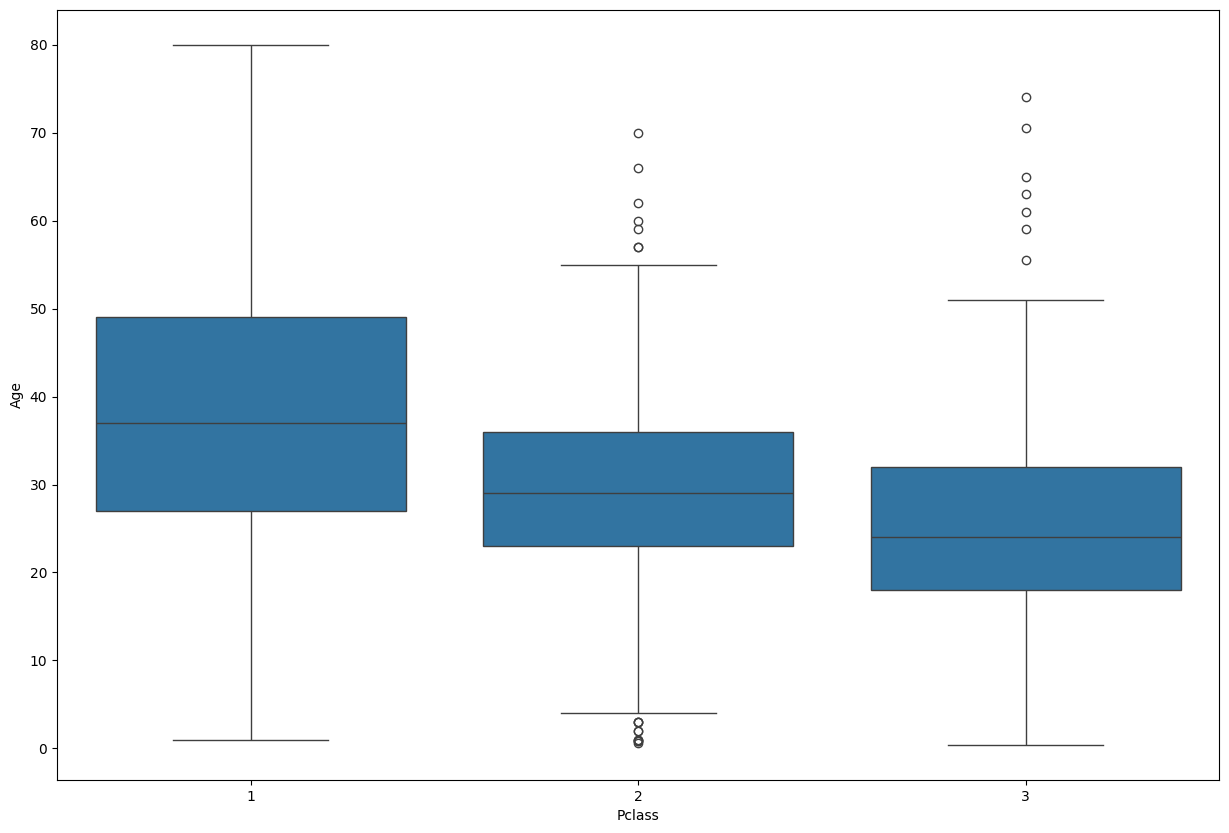

In [448]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Pclass', y='Age', data=train)
plt.show()

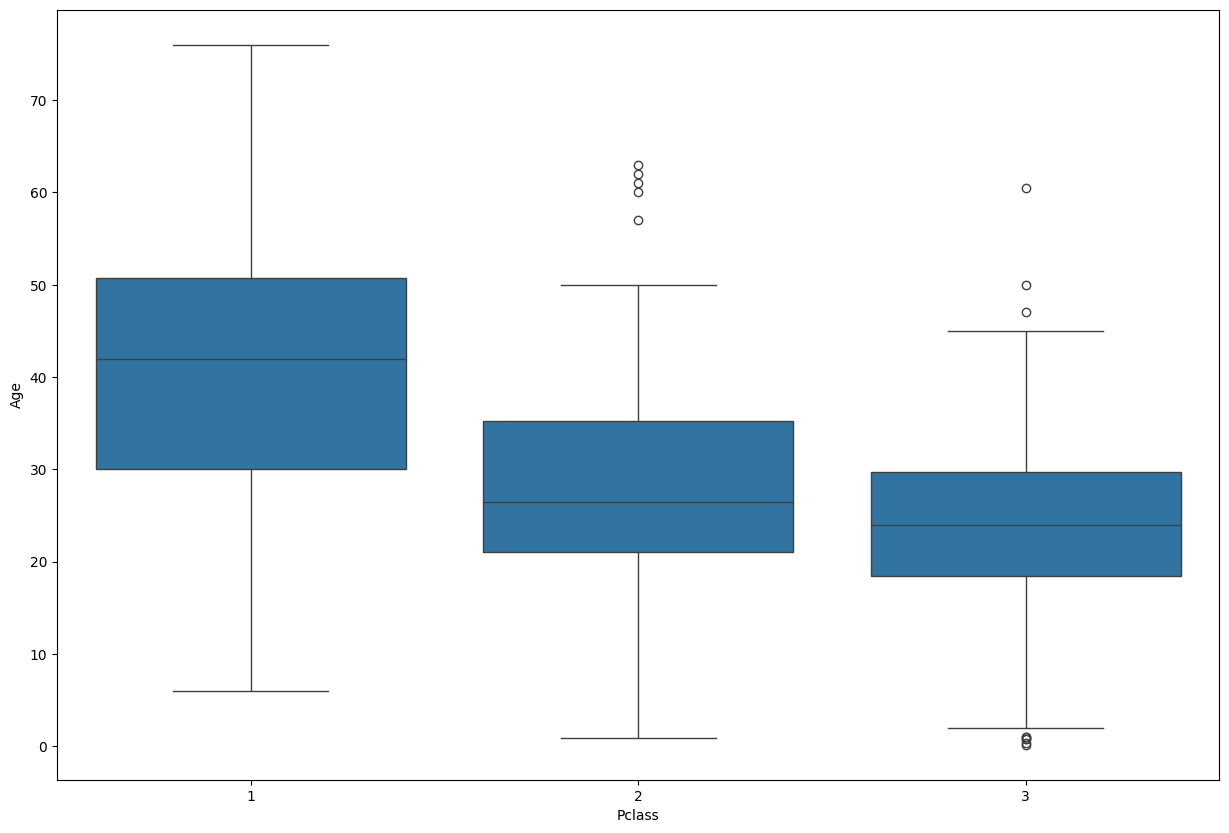

In [449]:
plt.figure(figsize=(15,10))
sns.boxplot(x='Pclass', y='Age', data=X_test)
plt.show()

## Feature Engineering 

### Calculate the mean of each Pclass and Replace with NaN values

In [450]:
mean_age_by_pclass = train.groupby('Pclass')['Age'].mean()
mean_age_by_pclasstest = X_test.groupby('Pclass')['Age'].mean()

print(mean_age_by_pclass)
print(mean_age_by_pclasstest)


Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64
Pclass
1    40.918367
2    28.777500
3    24.027945
Name: Age, dtype: float64


In [451]:
def replaceAgetrain(row):
    Age = row['Age']
    Pclass = row['Pclass']

    if pd.isnull(Age):  # Use pd.isnull to check for NaN
        if Pclass == 1:  # Corrected the equality check (use == instead of =)
            return 40
        elif Pclass == 2:  # Use elif for multiple conditions
            return 28
        else:
            return 24  # Default for other Pclasses
    else:
        return Age


def replaceAgetest(row):
    Age = row['Age']
    Pclass = row['Pclass']

    if pd.isnull(Age):  # Use pd.isnull to check for NaN
        if Pclass == 1:  # Corrected the equality check (use == instead of =)
            return 38
        elif Pclass == 2:  # Use elif for multiple conditions
            return 29
        else:
            return 25  # Default for other Pclasses
    else:
        return Age


        

        

In [452]:
train['Age'] = train.apply(replaceAge, axis=1)
X_test['Age'] = X_test.apply(replaceAge, axis=1)



## Dropping the columns we don't need 

In [453]:
train.drop(['Ticket','Cabin','Name'],inplace=True,axis=1)
X_test.drop(['Ticket','Cabin','Name'],inplace=True,axis=1)

### Handle Missing values from Cabin and create hasCabin

In [454]:
# # Fill missing values for the 'Cabin' column and create 'HasCabin' feature
# train['Cabin'] = train['Cabin'].fillna(0)
# train['HasCabin'] = train['Cabin'].notnull().astype(int)

# # Drop 'Cabin' after creating the 'HasCabin' feature
# train.drop(['Cabin'], inplace=True, axis=1)
# X_test.drop(['Cabin'], inplace=True, axis=1, errors='ignore')

### Drop missing values from embarked

In [455]:
train=train.dropna(axis=0,how='any')

### Check the corellation between the genders and the survival 

<Axes: xlabel='Survived', ylabel='count'>

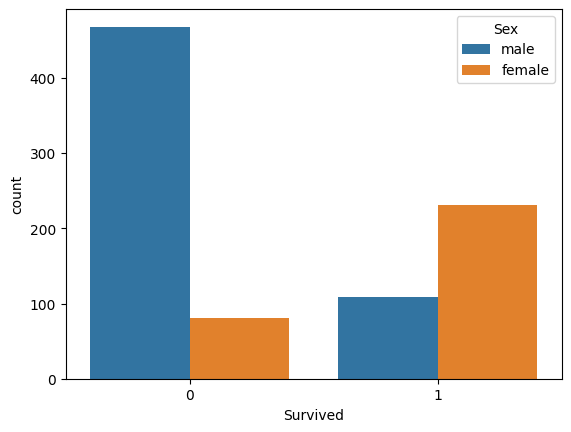

In [456]:
sns.countplot(x= 'Survived',hue='Sex',data=train)


### We can identify that males tend not to survive therefore we will have a feature male 

In [457]:
# sex=pd.get_dummies(train['Sex'],drop_first=True)




### Checking the distribution of the fare price 

<Axes: xlabel='Fare', ylabel='Count'>

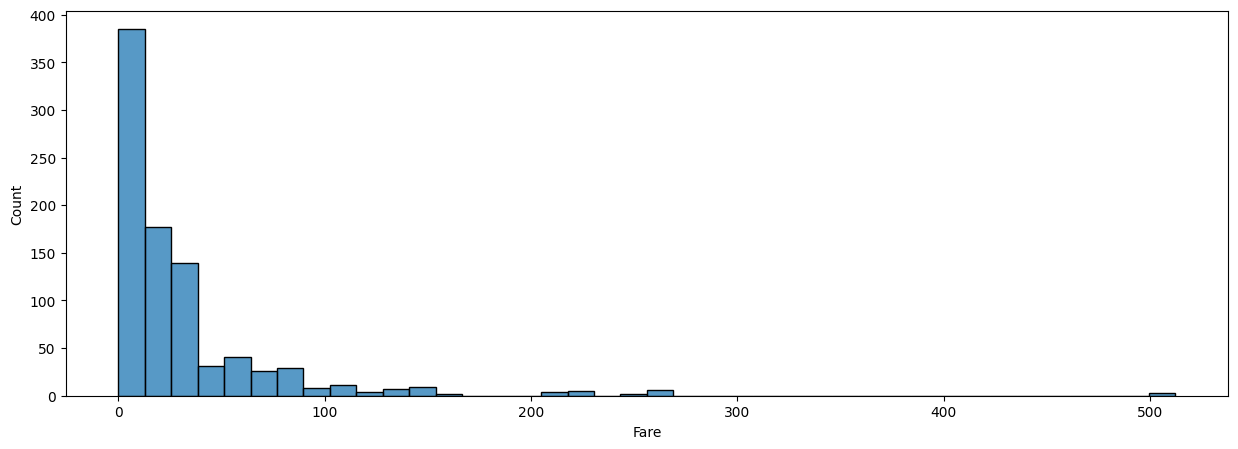

In [458]:
plt.figure(figsize=(15,5))
sns.histplot(train['Fare'],bins=40)

### We can clearly see that the distribution of fare prices is not 'normal' (Gaussian); therefore, we apply np.log to make it more normal

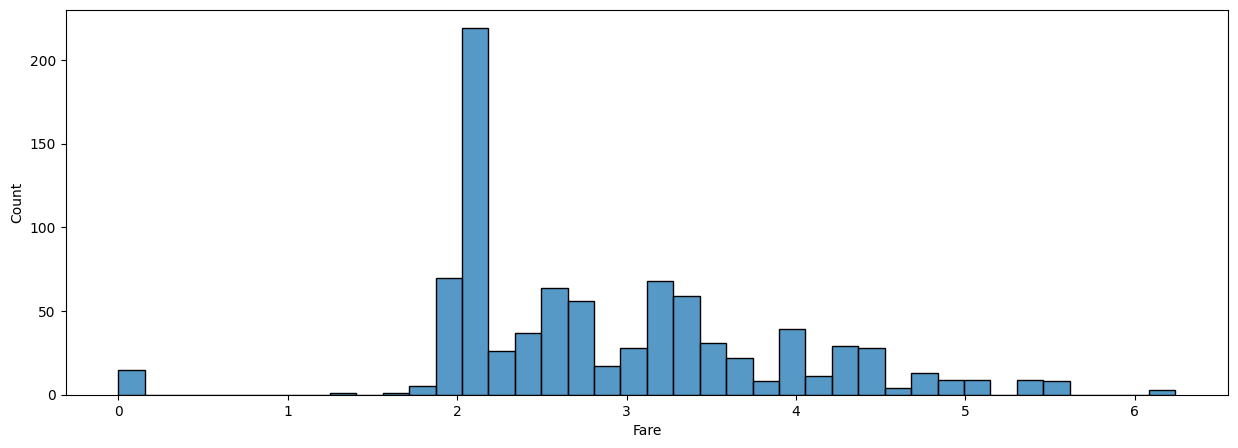

In [459]:
train_fare = train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
plt.figure(figsize=(15,5))
sns.histplot(train_fare,bins=40)

fare=train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)


### One - Hot encoding the Embarked and sex and dropping missing values 

In [460]:
sex=pd.get_dummies(train['Sex'],drop_first=True, dtype=int)
emb=pd.get_dummies(train['Embarked'],drop_first=True,dtype=int)

In [461]:
y_train=train['Survived']
train.drop(['Embarked','Sex','Survived','Fare'],inplace=True,axis=1)

## Create the training set by spliting into Y and X training sets 

In [462]:

X_train=pd.concat([train,sex,emb,fare],axis=1)



y_test.drop('PassengerId',inplace=True,axis=1)



X_train



,PassengerId,Pclass,Age,SibSp,Parch,male,Q,S,Fare
0,1,3,22.0,1,0,1,0,1,1.981001
1,2,1,38.0,1,0,0,0,0,4.266662
2,3,3,26.0,0,0,0,0,1,2.070022
3,4,1,35.0,1,0,0,0,1,3.972177
4,5,3,35.0,0,0,1,0,1,2.085672
...,...,...,...,...,...,...,...,...,...
886,887,2,27.0,0,0,1,0,1,2.564949
887,888,1,19.0,0,0,0,0,1,3.401197
888,889,3,25.0,1,2,0,0,1,3.154870
889,890,1,26.0,0,0,1,0,0,3.401197


# Logistic Regression

In [463]:
# Drop rows with any missing values
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]  # Ensure y_train aligns with X_train
test_fare=X_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
test_sex=pd.get_dummies(X_test['Sex'],drop_first=True)
test_emb=pd.get_dummies(X_test['Embarked'],drop_first=True)
X_test.drop(['Embarked','Sex','Fare'],inplace=True,axis=1)
X_test=pd.concat([X_test,test_sex,test_emb,test_fare],axis=1)
Y_test=pd.concat([X_test,test_sex,test_emb,test_fare,y_test],axis=1)
Y_test=Y_test.dropna(axis=0,how='any')
y_test=Y_test['Survived']



test_passenger_ids = X_test['PassengerId']


In [472]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# --- Predict ---
predictions = model.predict(X_test)

# --- Submission ---
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions.astype(int)
})

# Save to CSV
submission.to_csv('submission3.csv', index=False)
print("✅ Submission file created: submission.csv")
# Evaluate the model
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))
print("🧱 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
print("📉 Mean Squared Error:", mse)

✅ Submission file created: submission.csv
✅ Accuracy: 0.9330143540669856
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.95       266
           1       0.87      0.95      0.91       152

    accuracy                           0.93       418
   macro avg       0.92      0.94      0.93       418
weighted avg       0.94      0.93      0.93       418

🧱 Confusion Matrix:
 [[245  21]
 [  7 145]]
📉 Mean Squared Error: 0.06698564593301436


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [465]:
rnd_clf=RandomForestClassifier(n_estimators=1000,max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(X_train,y_train)
y_pred=rnd_clf.predict(X_test)

In [466]:
print(X_train.columns)
print(X_test.columns)


Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'male', 'Q', 'S',
       'Fare'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'male', 'Q', 'S',
       'Fare'],
      dtype='object')


In [467]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.8779904306220095
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       266
           1       0.91      0.74      0.81       152

    accuracy                           0.88       418
   macro avg       0.89      0.85      0.86       418
weighted avg       0.88      0.88      0.87       418

[[255  11]
 [ 40 112]]


# XGboost

In [468]:
# Create an XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))
print("🧱 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Accuracy: 0.8181818181818182
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       266
           1       0.75      0.74      0.75       152

    accuracy                           0.82       418
   macro avg       0.80      0.80      0.80       418
weighted avg       0.82      0.82      0.82       418

🧱 Confusion Matrix:
 [[229  37]
 [ 39 113]]


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [17:36:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
